In [29]:
import numpy as np

from lib.data_preprocessing import remove_correlated_columns
from lib.ds.bird_classes import NUM_CLASSES
from lib.ds.dataset_loading import load_all_data
from lib.ds.dataset_splitting import split
from lib.ds.torch_dataset import create_data_loader
from lib.model.attention_classifier import AttentionClassifier, AttentionClassifierHyperParameters
from lib.attention_classifier_training import train_attention_classifier_with_cv, train_attention_classifier, test_attention_classifier
from lib.training_hyper_parameters import TrainingHyperParameters
from lib.random import set_random_seed
import lib.torch_device as tdev
import torch.optim.lr_scheduler as lr_scheduler

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
# tdev.PREFERRED = 'cpu'
device = tdev.get_torch_device()
device

device(type='cuda', index=0)

In [10]:
data_train, labels_train, data_test, labels_test = split(*load_all_data('dataset'), seed=69420)

In [11]:
data_train, data_test = remove_correlated_columns(data_train, data_test)

In [12]:
data_train.shape

(960, 100, 268)

In [13]:
set_random_seed(42)
subset_indices = [
    bird * data_train.shape[0] // 6 + sample_nr
    for bird in range(6)
    for sample_nr in range(10)
]
# data_train_subset = data_train[subset_indices, :, :]
# labels_train_subset = labels_train[subset_indices, :]
data_train_subset = data_train[subset_indices, :, :]
labels_train_subset = labels_train[subset_indices, :]
print(data_train_subset.shape)
print(labels_train_subset.shape)

(60, 100, 268)
(60, 100)


## Hyper Parameter

In [65]:
hyper_parameters = AttentionClassifierHyperParameters(
    d_model=256,
    num_heads=16,
    stack_size=1,
    dropout=0.1,
    out_size=NUM_CLASSES,
    in_features=data_train.shape[-1],
)

In [63]:
EPOCH_MULTIPLIER = 0.5

training_hyper_parameters = TrainingHyperParameters(
    batch_size=64,
    num_epochs=int(150 * EPOCH_MULTIPLIER),
    lr=1e-2,
    lr_scheduler_provider=lambda optimizer: lr_scheduler.MultiStepLR(
        optimizer, 
        milestones=[int(m * EPOCH_MULTIPLIER) for m in [10, 30, 60, 100]], 
        gamma=0.1
    )
)

## Training

Training AttentionClassifier with 333831 parameters
loss_weight = tensor([ 1.0000, 15.6667, 10.0378, 10.7933, 38.1560, 18.1827, 20.9909],
       device='cuda:0')
Training Epoch 0  : epoch_loss = 148.789296, num_correct = 11643, num_samples = 85536, acc = 0.136118, bacc = 0.146039
Training Epoch 1  : epoch_loss = 91.835227, num_correct = 18689, num_samples = 85536, acc = 0.218493, bacc = 0.287063
Training Epoch 2  : epoch_loss = 46.025871, num_correct = 21923, num_samples = 85536, acc = 0.256301, bacc = 0.375565
Training Epoch 3  : epoch_loss = 28.318825, num_correct = 25605, num_samples = 85536, acc = 0.299348, bacc = 0.434261
Training Epoch 4  : epoch_loss = 20.444504, num_correct = 26151, num_samples = 85536, acc = 0.305731, bacc = 0.473543
Training Epoch 5  : epoch_loss = 14.144889, num_correct = 27487, num_samples = 85536, acc = 0.321350, bacc = 0.512894
Training Epoch 6  : epoch_loss = 10.612706, num_correct = 30878, num_samples = 85536, acc = 0.360994, bacc = 0.546657
Training Ep

<Figure size 1440x1440 with 0 Axes>

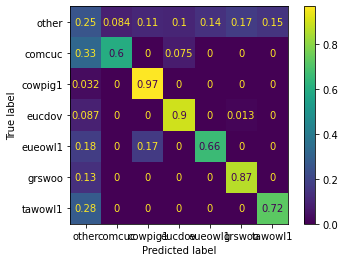

Training AttentionClassifier with 333831 parameters
loss_weight = tensor([ 1.0000, 14.8653,  9.3991, 10.2516, 36.2365, 18.3394, 20.3173],
       device='cuda:0')
Training Epoch 0  : epoch_loss = 133.924977, num_correct = 12542, num_samples = 85536, acc = 0.146628, bacc = 0.222084
Training Epoch 1  : epoch_loss = 85.066943, num_correct = 19409, num_samples = 85536, acc = 0.226910, bacc = 0.321477
Training Epoch 2  : epoch_loss = 64.789380, num_correct = 21659, num_samples = 85536, acc = 0.253215, bacc = 0.390090
Training Epoch 3  : epoch_loss = 33.075932, num_correct = 24971, num_samples = 85536, acc = 0.291936, bacc = 0.438373
Training Epoch 4  : epoch_loss = 24.224616, num_correct = 27420, num_samples = 85536, acc = 0.320567, bacc = 0.475885
Training Epoch 5  : epoch_loss = 17.817487, num_correct = 26669, num_samples = 85536, acc = 0.311787, bacc = 0.509730
Training Epoch 6  : epoch_loss = 12.401033, num_correct = 32818, num_samples = 85536, acc = 0.383675, bacc = 0.540031
Training Ep

<Figure size 1440x1440 with 0 Axes>

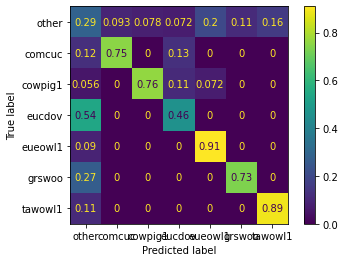

Training AttentionClassifier with 333831 parameters
loss_weight = tensor([ 1.0000, 15.2268,  9.4849, 10.3441, 37.8755, 18.3690, 19.9984],
       device='cuda:0')
Training Epoch 0  : epoch_loss = 161.892421, num_correct = 12669, num_samples = 85536, acc = 0.148113, bacc = 0.202377
Training Epoch 1  : epoch_loss = 106.102389, num_correct = 16962, num_samples = 85536, acc = 0.198302, bacc = 0.283931
Training Epoch 2  : epoch_loss = 86.119950, num_correct = 23783, num_samples = 85536, acc = 0.278047, bacc = 0.330471
Training Epoch 3  : epoch_loss = 59.588391, num_correct = 19256, num_samples = 85536, acc = 0.225122, bacc = 0.363315
Training Epoch 4  : epoch_loss = 61.075933, num_correct = 21191, num_samples = 85536, acc = 0.247744, bacc = 0.388447
Training Epoch 5  : epoch_loss = 28.878151, num_correct = 24879, num_samples = 85536, acc = 0.290860, bacc = 0.426102
Training Epoch 6  : epoch_loss = 19.121951, num_correct = 29650, num_samples = 85536, acc = 0.346638, bacc = 0.464487
Training E

<Figure size 1440x1440 with 0 Axes>

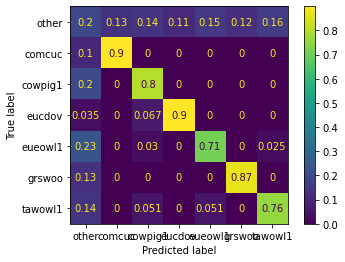

Training AttentionClassifier with 333831 parameters
loss_weight = tensor([ 1.0000, 15.1211,  9.6407, 10.6719, 39.2021, 18.1083, 20.8455],
       device='cuda:0')
Training Epoch 0  : epoch_loss = 134.851174, num_correct = 13342, num_samples = 85536, acc = 0.155981, bacc = 0.193327
Training Epoch 1  : epoch_loss = 75.622581, num_correct = 19367, num_samples = 85536, acc = 0.226419, bacc = 0.308274
Training Epoch 2  : epoch_loss = 67.803190, num_correct = 20384, num_samples = 85536, acc = 0.238309, bacc = 0.377671
Training Epoch 3  : epoch_loss = 67.227912, num_correct = 21376, num_samples = 85536, acc = 0.249906, bacc = 0.421089
Training Epoch 4  : epoch_loss = 65.673738, num_correct = 21058, num_samples = 85536, acc = 0.246189, bacc = 0.436503
Training Epoch 5  : epoch_loss = 37.175552, num_correct = 25001, num_samples = 85536, acc = 0.292286, bacc = 0.473265
Training Epoch 6  : epoch_loss = 20.464799, num_correct = 26971, num_samples = 85536, acc = 0.315318, bacc = 0.505390
Training Ep

<Figure size 1440x1440 with 0 Axes>

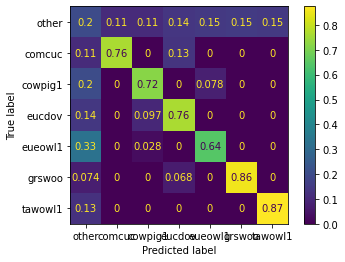

Training AttentionClassifier with 333831 parameters
loss_weight = tensor([ 1.0000, 14.8811,  9.5345, 10.5929, 36.9140, 18.1909, 20.4874],
       device='cuda:0')
Training Epoch 0  : epoch_loss = 143.633378, num_correct = 15608, num_samples = 85536, acc = 0.182473, bacc = 0.200266
Training Epoch 1  : epoch_loss = 103.317888, num_correct = 18319, num_samples = 85536, acc = 0.214167, bacc = 0.288154
Training Epoch 2  : epoch_loss = 84.023175, num_correct = 20643, num_samples = 85536, acc = 0.241337, bacc = 0.367704
Training Epoch 3  : epoch_loss = 43.787549, num_correct = 24114, num_samples = 85536, acc = 0.281916, bacc = 0.420792
Training Epoch 4  : epoch_loss = 42.307649, num_correct = 23778, num_samples = 85536, acc = 0.277988, bacc = 0.447828
Training Epoch 5  : epoch_loss = 27.406669, num_correct = 26165, num_samples = 85536, acc = 0.305895, bacc = 0.482399
Training Epoch 6  : epoch_loss = 16.634046, num_correct = 29788, num_samples = 85536, acc = 0.348251, bacc = 0.513369
Training E

<Figure size 1440x1440 with 0 Axes>

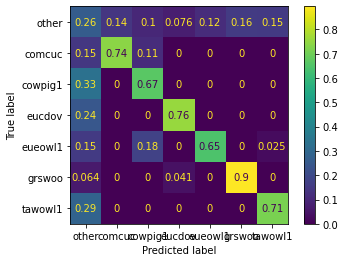

Training AttentionClassifier with 333831 parameters
loss_weight = tensor([ 1.0000, 14.8491,  9.6396, 10.4669, 35.7964, 17.6575, 20.4754],
       device='cuda:0')
Training Epoch 0  : epoch_loss = 153.150709, num_correct = 12914, num_samples = 85536, acc = 0.150977, bacc = 0.164461
Training Epoch 1  : epoch_loss = 77.185489, num_correct = 17750, num_samples = 85536, acc = 0.207515, bacc = 0.288111
Training Epoch 2  : epoch_loss = 39.513070, num_correct = 24558, num_samples = 85536, acc = 0.287107, bacc = 0.366503
Training Epoch 3  : epoch_loss = 35.458420, num_correct = 23399, num_samples = 85536, acc = 0.273557, bacc = 0.416156
Training Epoch 4  : epoch_loss = 22.662012, num_correct = 26260, num_samples = 85536, acc = 0.307005, bacc = 0.456679
Training Epoch 5  : epoch_loss = 13.870475, num_correct = 27193, num_samples = 85536, acc = 0.317913, bacc = 0.502590
Training Epoch 6  : epoch_loss = 11.184181, num_correct = 30531, num_samples = 85536, acc = 0.356937, bacc = 0.537305
Training Ep

In [ ]:
set_random_seed(42)

train_attention_classifier_with_cv(
    data_train, 
    labels_train, 
    hyper_parameters, 
    training_hyper_parameters, 
    device
)

In [43]:
set_random_seed(42)

attention_classifier = train_attention_classifier(
    data_train_subset, 
    labels_train_subset, 
    hyper_parameters, 
    training_hyper_parameters, 
    device
)

Training AttentionClassifier with 101383 parameters
loss_weight = tensor([ 1.0000,  9.9554,  6.6479,  8.8590, 38.6731, 20.2111, 18.9717],
       device='cuda:0')
Epoch  0: epoch_loss = 872.299805, num_correct =  3291, num_samples =  5940, acc = 0.554040, bacc = 0.166045
Epoch  1: epoch_loss = 71740.179688, num_correct =   553, num_samples =  5940, acc = 0.093098, bacc = 0.168584
Epoch  2: epoch_loss = 5500.583496, num_correct =   571, num_samples =  5940, acc = 0.096128, bacc = 0.159407
Epoch  3: epoch_loss = 11080.972656, num_correct =  3779, num_samples =  5940, acc = 0.636195, bacc = 0.159181
Epoch  4: epoch_loss = 7970.864258, num_correct =   278, num_samples =  5940, acc = 0.046801, bacc = 0.170734
Epoch  5: epoch_loss = 3235.985840, num_correct =   287, num_samples =  5940, acc = 0.048316, bacc = 0.176006
Epoch  6: epoch_loss = 31660.042969, num_correct =   642, num_samples =  5940, acc = 0.108081, bacc = 0.178273
Epoch  7: epoch_loss = 1427.049438, num_correct =   686, num_sampl

Evaluated with loss = 0.10950049904460457, acc = 0.14305555555555555, bacc = 0.19999653682899884


<Figure size 1440x1440 with 0 Axes>

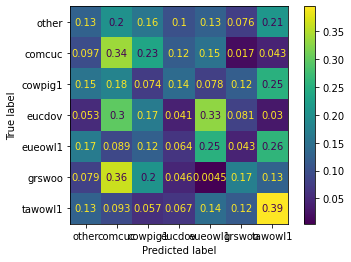

In [44]:
# test_loader = create_offset_data_loader(np.random.normal(size=(240, 100, 268)), np.random.randint(0, 7, size=(240, 100)))
test_loader = create_data_loader(data_test, labels_test)
test_attention_classifier(attention_classifier, test_loader, device)